# Who said it?

This notbook uses a DistilBert model to determine which character of the TV-show "The Office" is likely to say a given sentence. <br>
It is pretrained on reals script data from the show.

# Setup

In [46]:
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import pandas as pd
import json
import gc

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

save_directory = "models/"

In [3]:
import sys
sys.path.append("..")

from preprocessing_nlp import preprocess, extract_features
from utils import print_episode

PATH = "../data/"
FILE = "the-office-lines_scripts.csv"

In [4]:
df = pd.read_csv(PATH+FILE, sep=",", index_col='id')

# list of 5 most common speakers
speakers = df['speaker'].value_counts().head(5).index.tolist()

# filter dataframe to only include the 5 most common speakers
df = df[df['speaker'].isin(speakers)]
df['encoded_speaker'] = df['speaker'].astype('category').cat.codes

# only keep the speaker and line columns
df = df[['speaker', 'line_text', 'encoded_speaker']]

data_text = df['line_text'].to_list()
data_labels = df['encoded_speaker'].to_list()

In [5]:
# this may be used for further finetuning but retrieved not sufficient results in simple tests
from sklearn.utils import class_weight
import numpy as np

# create class weight dictionary
class_weight_dict = class_weight.compute_class_weight('balanced', classes=np.unique(data_labels), y=data_labels)
class_weight_dict = dict(enumerate(class_weight_dict))

In [6]:
# list of unique speakers with their encodings
dict(zip(df['speaker'], df['encoded_speaker']))

sorted_speakers = ["Andy", "Dwight", "Jim", "Michael", "Pam"]

In [7]:
df.head()

,speaker,line_text,encoded_speaker
id,,,
1,Michael,All right Jim. Your quarterlies look very good...,3
2,Jim,"Oh, I told you. I couldn't close it. So...",2
3,Michael,So you've come to the master for guidance? Is ...,3
4,Jim,"Actually, you called me in here, but yeah.",2
5,Michael,"All right. Well, let me show you how it's done.",3


In [8]:
# mmax length of a sentence
df['line_text'].str.split(" ").str.len().mean()

12.629958406610278

In [9]:
from sklearn.model_selection import train_test_split

# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_text, data_labels, test_size=0.2, random_state=0)

# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [11]:
class TheOfficeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
         input_ids = torch.tensor(self.encodings['input_ids'][idx])
         labels = torch.tensor(self.labels[idx])

         return input_ids, labels

    def __len__(self):
        return len(self.labels)

In [12]:
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=32)
val_dataset = TheOfficeDataset(val_encodings, val_labels)

In [14]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Set the optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=4e-5)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=32)
train_dataset = TheOfficeDataset(train_encodings, train_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

device = "cpu"

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [34]:
# Train the model
model.train()
model = model.to(device)


for epoch in range(5):
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    #eval 
    model.eval()

    val_loss = 0
    val_accuracy = 0
    for batch in tqdm(val_loader):
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=labels)
            val_loss += outputs.loss.item()
            val_accuracy += (outputs.logits.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)
    print(f"Epoch {epoch} - Validation loss: {val_loss} - Validation accuracy: {val_accuracy}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

Epoch 0 - Validation loss: 1.3938035879816328 - Validation accuracy: 0.4139567341242149


100%|████████████████████████████████████████| 448/448 [00:03<00:00, 134.47it/s]


Epoch 1 - Validation loss: 1.3625405912420578 - Validation accuracy: 0.4316817864619679


100%|████████████████████████████████████████| 448/448 [00:03<00:00, 136.26it/s]


Epoch 2 - Validation loss: 1.4684291623000587 - Validation accuracy: 0.4237264480111654


100%|████████████████████████████████████████| 448/448 [00:03<00:00, 118.38it/s]


Epoch 3 - Validation loss: 1.7043923086353712 - Validation accuracy: 0.4160502442428472


100%|████████████████████████████████████████| 448/448 [00:03<00:00, 134.07it/s]

Epoch 4 - Validation loss: 2.065169338935188 - Validation accuracy: 0.4129797627355199


In [35]:
# save model to disk
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
torch.save(model.state_dict(), save_directory + 'classifier_model.pth')

In [35]:
# load model from disk
model.load_state_dict(torch.load(save_directory + 'classifier_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
test_sample_str = "Hi i'm Michael Scott, and I'm the regional manager."
test_sample = tokenizer.encode(test_sample_str, truncation=True, padding=True, return_tensors='pt')
test_sample = test_sample.to(device)
output = model(test_sample)
# visualize
import plotly.express as px
output = torch.softmax(output.logits, dim=1)
output = output.detach().cpu().numpy()
px.bar(x=sorted_speakers, y=output[0], title=f"Model evaluation - Test sentence: '{test_sample_str}'")


In [30]:
test_sample_str = "Good to see you!"
test_sample = tokenizer.encode(test_sample_str, truncation=True, padding=True, return_tensors='pt')
test_sample = test_sample.to(device)
output = model(test_sample)
# visualize
import plotly.express as px
output = torch.softmax(output.logits, dim=1)
output = output.detach().cpu().numpy()
px.bar(x=sorted_speakers, y=output[0], title=f"Model evaluation - Test sentence: '{test_sample_str}'")

Best examples:
- "And this is how to stab someone in the back."
- "Hi i'm Michael Scott, and I'm the regional manager."
- "That's what she said."
- "Beesly, you are the best"
- "Anyone wants to join me on a drink after work?"

In [44]:
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [45]:
# create a confusion matrix evaluating the above class predictions

print("Validation dataset size: {}".format(len(val_dataset)))

val_predictions = []

for batch in tqdm(val_loader):
    input_ids, labels = batch
    input_ids = input_ids.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=labels)
        val_predictions.extend(outputs.logits.argmax(1).tolist())


Validation dataset size: 7165


100%|██████████████████████████████████████| 7165/7165 [00:48<00:00, 147.95it/s]


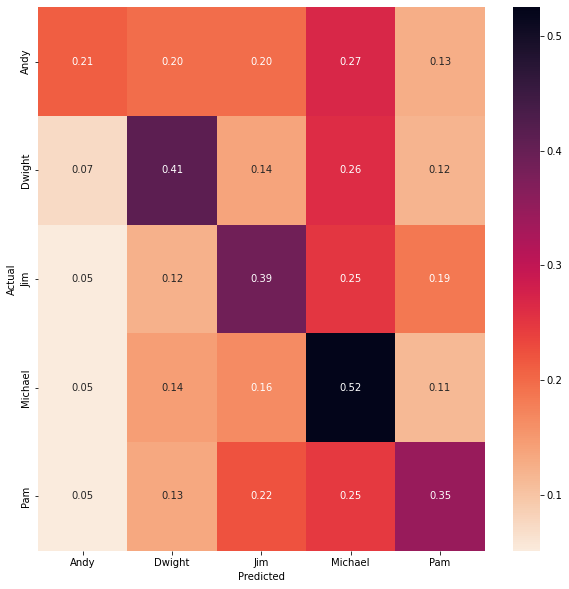

In [46]:
# create a confusion matrix evaluating the above class predictions (normalized)
cm = confusion_matrix(val_labels, val_predictions, normalize='true')

# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='rocket_r', annot=True, fmt='.2f', xticklabels=sorted_speakers, yticklabels=sorted_speakers)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
def predict(inputs):
    # Convert input data to tensors
    inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
    # Make predictions
    outputs = model(inputs['input_ids'], inputs['attention_mask'])
    # Apply softmax to get class probabilities
    probs = torch.nn.functional.softmax(outputs, dim=1)
    # Get predicted class index
    _, pred = torch.max(probs, dim=1)
    # Convert predicted class index to class label
    labels = [val_dataset.get_label_by_index(i.item()) for i in pred]
    return labels


In [36]:
import shap
from transformers import pipeline

pipe = pipeline('text-classification', model=model, tokenizer=tokenizer, device='cpu')
explainer = shap.Explainer(pipe)
shap_values = explainer(val_texts[15:17])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [00:19, 19.76s/it]               


In [37]:
# visualize the first prediction's explanation
shap.plots.text(shap_values)

In [79]:
explained_texts = val_texts[37:42]
shap_values = explainer(explained_texts)

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 2/5 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 5/5 [00:24<00:00,  3.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [00:40, 10.07s/it]                       


In [69]:
# lines considered here
explained_texts

["It's a good shredder, it just keeps breaking.",
 'Can you send Dwight in here?',
 "With our firm, you'll be building equity for long after they've retired your number.",
 "Obviously I'm going to clean up.",
 "It's all right. It's all right."]

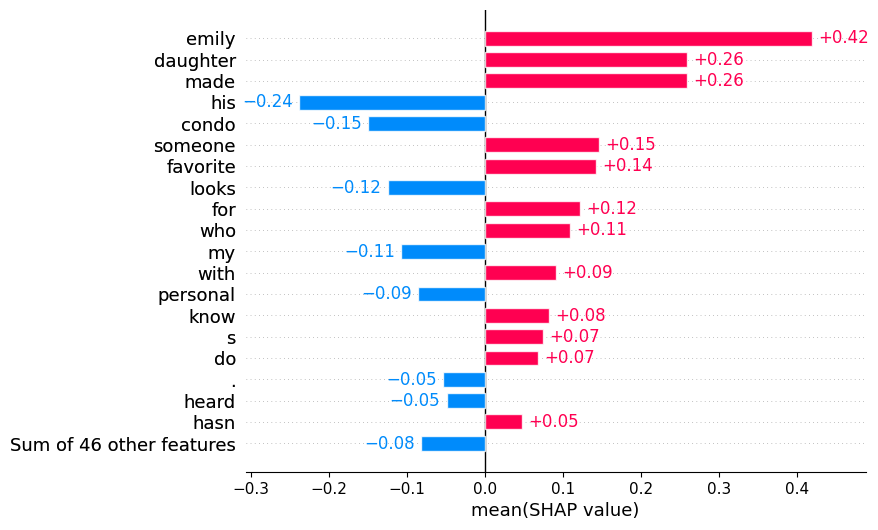

In [83]:
shap.plots.bar(shap_values[:,:,4].mean(0), max_display=20, show=False)
plt.gcf().set_size_inches(8, 6)
plt.show()
